Import relevant/needed packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from scipy import stats
import requests
import re

First we need to scrape player contract data from basketball-reference using BeautifulSoup

In [37]:
url = 'https://www.basketball-reference.com/contracts/players.html'
page = requests.get(url)
soup = bs(page.content, 'html.parser')

raw_players = soup.find('table', class_ = 'sortable stats_table').findAll('a')
raw_salaries = soup.find('table', class_ = 'sortable stats_table').findAll('td', class_='right')
test =  soup.find('table', class_ = 'sortable stats_table').findAll('href')

The resulting salary will have '$' and ',' characters in it, so lets get rid of those and convert the salary into a float. 

In [38]:
parsed_salaries = []
parsed_players = []
parsed_teams = []
for salary in raw_salaries:
    if 'y1' in str(salary):
        parsed_salaries.append(float(salary.getText().strip('$').replace(',', '')))

Instantiate a pandas dataframe to hold our scraped info. 

In [39]:
player_salaries = pd.DataFrame()

When we display "raw_players", it comes out as such:

Stephen Curry

GSW

LeBron James

CLE

So I separate the player and team into different arrays based on the counter value and using the mod operator. 

In [40]:
for counter, player in enumerate(raw_players):
    if counter % 2 == 0:
        parsed_players.append(player.getText())
    else:
        parsed_teams.append(player.getText())

The URL stems are in some lines within the raw_players array. So I just say if the text '/players/' is in the line, store it in the url_stems array. Usually the stem is characters 9 to 34, but it is slightly shorter for players with short last names. I get rid of any unnecessary characters by using strip(). 

In [41]:
url_stems = []
for url_stem in raw_players:
    if 'href=\"/players/' in str(url_stem):
        url_stems.append(str(url_stem)[9:34].strip('Z').strip('>').strip('"'))

Lets store everything into our dataframe, and see what it looks like. 

In [42]:
player_salaries['Player'] = parsed_players
player_salaries['Team'] = parsed_teams
player_salaries['Salary'] = parsed_salaries
player_salaries['url_stem'] = url_stems

player_salaries.head()

,Player,Team,Salary,url_stem
0,Stephen Curry,GSW,34682550.0,/players/c/curryst01.html
1,LeBron James,CLE,33285709.0,/players/j/jamesle01.html
2,Paul Millsap,DEN,31269231.0,/players/m/millspa01.html
3,Gordon Hayward,BOS,29727900.0,/players/h/haywago01.html
4,Blake Griffin,DET,29512900.0,/players/g/griffbl01.html


Lets plot a histogram of player salaries throughout the NBA. 

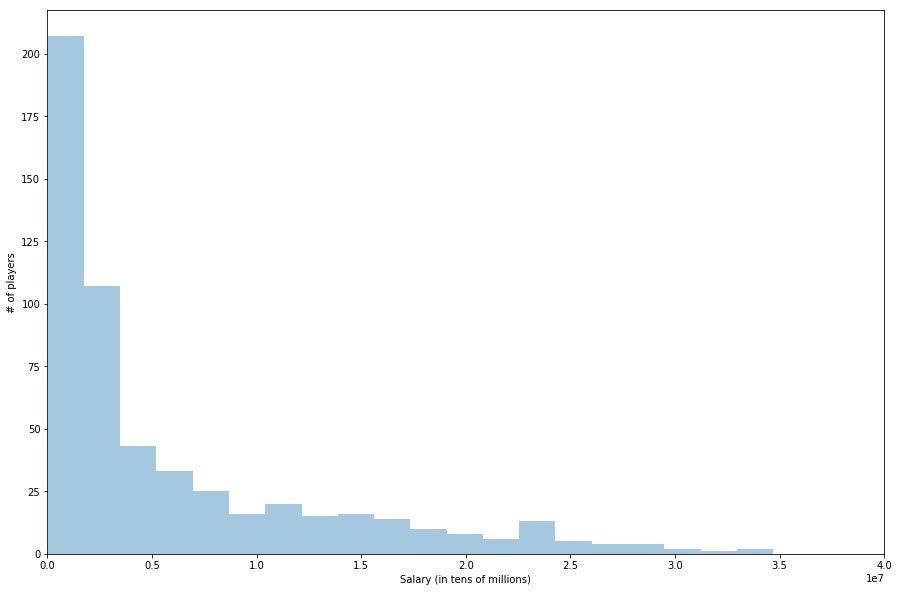

count    5.510000e+02
mean     6.086612e+06
std      7.210965e+06
min      1.722400e+04
25%      1.312611e+06
50%      2.550000e+06
75%      8.425512e+06
max      3.468255e+07
Name: Salary, dtype: float64

In [43]:
plt.figure(figsize=(15,10))

ax = sns.distplot(player_salaries.Salary,kde=False)
ax.set(xlabel='Salary (in tens of millions)', ylabel='# of players')
ax.set_xlim([0, 4e7])
plt.savefig("NBA_player_salary_distribution")

plt.show()

player_salaries.Salary.describe()

Heavy right tailed distribution. The mean salary is ~6 million, yet the median is only 2.5 million. The Stephen Curry and Lebron James' of the world are driving the mean upwards. 

Lets see what each team is paying out this year to their players. 

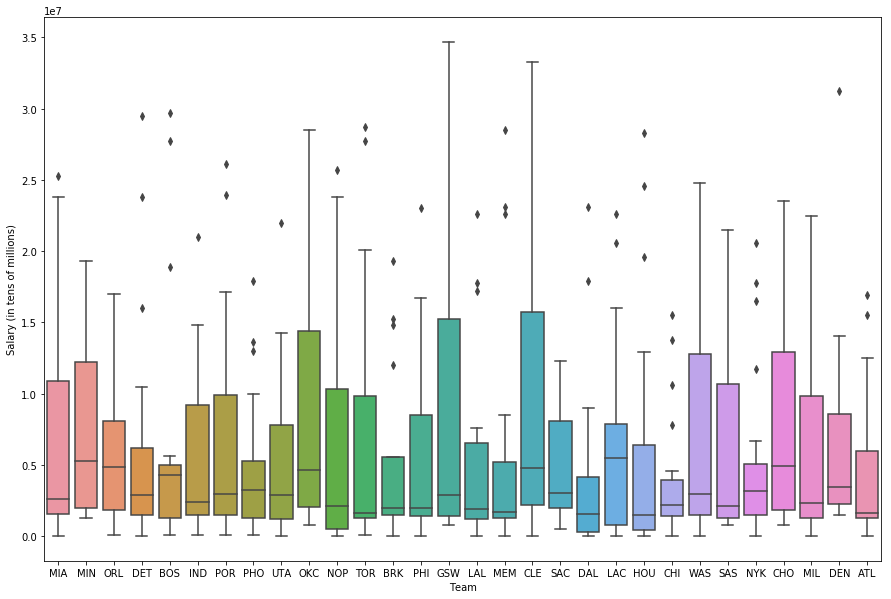

In [74]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Team',y='Salary', data=player_salaries)
ax.set(xlabel='Team', ylabel='Salary (in tens of millions)')
plt.savefig("NBA_player_salary_distribution_by_team")
plt.show()

As we saw in the previous histogram, there's a lot of outliers on the upper-end of the salary spectrum. We see most players on a team getting relatively the same amount, but a few who are getting significantly higher salaries. 



Importing current standings (wins, losses)

In [13]:
standings = pd.read_csv('nbastandings.csv')

Storing each team's total salary output. 

In [76]:
team_total_salary = player_salaries.groupby(['Team'],as_index=False).sum()

Add wins, losses, and win percentage to the dataframe. Also, I sort the dataframe so the plot comes out in order from "best" spending efficiency to "worst". 

In [77]:
team_wins = []
team_losses = []
team_win_percent = []
for counter,i in enumerate(team_total_salary.Team):
    for counter2, j in enumerate(standings.Team):
        if j in i:
            team_wins.append(standings.Win[counter2])
            team_losses.append(standings.Loss[counter2])
            team_win_percent.append(standings.WinPercent[counter2])

In [78]:
team_total_salary['Wins'] = team_wins
team_total_salary['Losses'] = team_losses
team_total_salary['WinPercent'] = team_win_percent
team_total_salary['SalaryWinPercent'] = team_total_salary['Salary']/team_total_salary['WinPercent']
team_total_salary['SalaryWin'] = team_total_salary['Salary']/team_total_salary['Wins']
team_total_salary = team_total_salary.sort_values(by='SalaryWinPercent')

First, I'm plotting each teams Salary divided by their win percentage. I use win percentage because some teams have played more games than others thus far into the season, so its acts as a standardization. A lower value is better, but it doesn't really have physical meaning. 

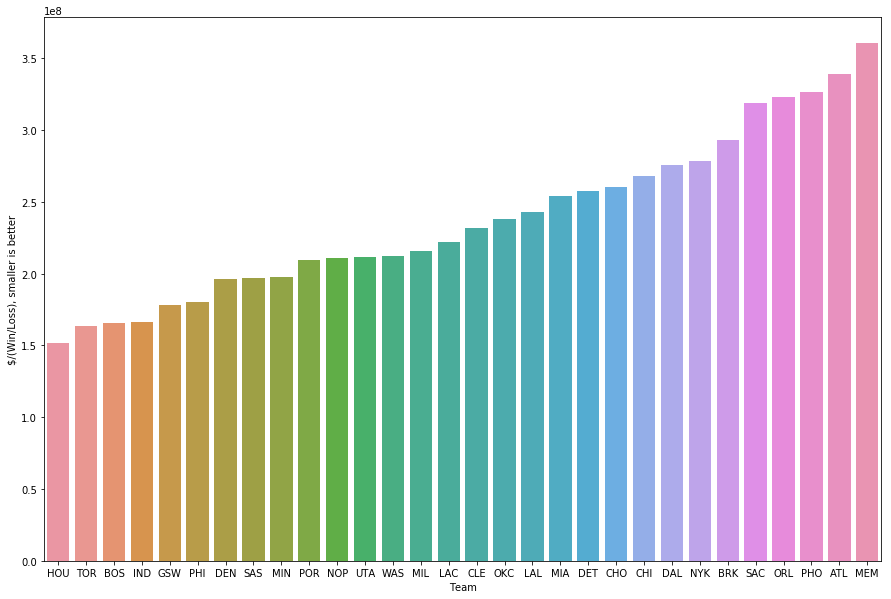

In [79]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x=team_total_salary['Team'], y=team_total_salary['SalaryWinPercent'])
ax.set(xlabel='Team', ylabel='$/(Win/Loss), smaller is better')
plt.savefig('salaryperwinpercent')
plt.show()

For the most part, it seems like the best teams come out on top. Some notable exceptions are IND, PHI, DEN, and NOP, which are better than expected. 

If we want some physical meaning that I could explain to a larger audience, lets answer the question "how many dollars is a team spending on their players per win?" 

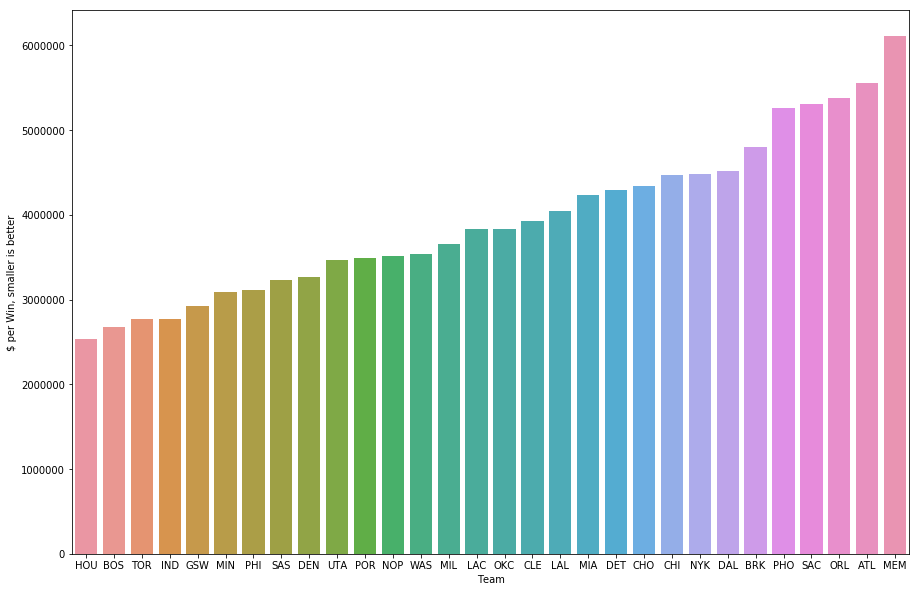

In [81]:
team_total_salary = team_total_salary.sort_values(by='SalaryWin')
plt.figure(figsize=(15,10))
ax = sns.barplot(x=team_total_salary['Team'], y=team_total_salary['Salary']/team_total_salary['Wins'])
ax.set(xlabel='Team', ylabel='$ per Win, smaller is better')
plt.savefig('salaryperwin')
plt.show()

Very similar result. 

Houston spends nearly 3.5 mil LESS to get a win compared to Memphis. That is a massive discrepancy and speaks to the dysfunction we see in Memphis this season (considering how decent they were last season). 